---
title: "FEM with Automatic Differentiation"
format:
  html:
    code-fold: false
---

In this notebook, we will use `Automatic differentiation` for a solid mechanics problem. We will use `Automatic differentiation` to compute:

- The gradient of the total energy with respect to the displacement
   $$ \boldsymbol{f}_\text{int} = \frac{\partial \Pi}{\partial \boldsymbol{u}} $$
- The Hessian of the total energy with respect to the displacement
    $$ \boldsymbol{K} = \frac{\partial^2 \Pi}{ \partial \boldsymbol{u}^2} $$


Another goal of this notebook is to get familiar with the `femsolver` library. We will use the `femsolver` library to ease various operations that are common in FEM. These operations include:

- Defining a finite element that uses the interpolation function and the quadrature rule.
- Operation to integrate the energy density function over the range of elements.

The `femsolver` library is a tiny library that is designed to ease the above operations. We will use the `jax` library to compute the gradient and Hessian of the total energy.

Lets start with necessary imports.

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
from jax import Array
import jax.numpy as jnp


import femsolver
from femsolver.utils import auto_vmap
from femsolver import Mesh, Operator, element


import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from femsolver.plotting import STYLE_PATH

First, we start with creating a mesh for a unit square.

In [20]:
mesh = Mesh.unit_square(10, 10)

n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

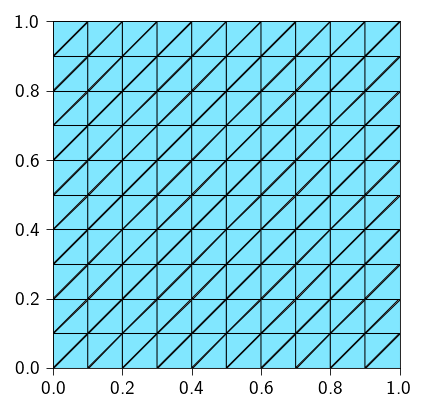

In [27]:
# | code-fold: true
# | fig-align: center
plt.style.use(STYLE_PATH)
plt.figure(figsize=(3, 3))
plt.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.5,
    cmap=cmc.managua_r,
)
plt.gca().set_aspect("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## Defining the constitutive behavior of the material

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


To ease the handling of the material paramters and later on ease the integration of the material parameters for computing energy density, we define a class `Material` that can be used to define the material parameters.

In [ ]:
from typing import NamedTuple

class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


mat = Material(mu=0.5, lmbda=1.0)


Now, we define bunch of functions to compute the strain, stress, and strain energy.

In [11]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.T)

@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)


## Defining Operator


In `femsolver`, we define a operator class that is capable of performing various mathematical operations on the mesh. For example,

-  Integrate a field (form of nodal values) over the mesh
   $$ \int_{\Omega} f(\mathbf{x}) d\Omega $$
-  Compute the gradient of a field
   $$ \nabla f(\mathbf{x}) $$
- Compute the field values at the quadrature points
   $$ f(\mathbf{x_i})$$


To perform these operations, the operator class requires the following information:
- The mesh (nodes and elements)
- The element type (e.g. triangle, quadrilateral, etc. with quadrature points)

Below, we define such an operator that can perform the above operations over `triangular` elements.


In [12]:
tri = element.Tri3()
op = Operator(mesh, tri)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

Now we can define a function that takes the nodal displacements and uses the above defined decorated `total_strain_energy` to compute the total energy.

In [13]:
@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    return total_strain_energy(u)


## Using automatic differentiation

We can use the `jax` library to compute the gradient and Hessian of the total energy.
The gradient is the internal force vector and the Hessian is the stiffness matrix.
Therefore, 

$$\boldsymbol{f}_\text{int} = \dfrac{\partial \Pi}{ \partial \boldsymbol{u}} $$

and

$$ \boldsymbol{K} = \dfrac{ \partial \boldsymbol{f}}{ \partial\boldsymbol{u}} $$


In [ ]:
gradient = jax.jacrev(total_energy)
hessian = jax.jacfwd(gradient)

## Solve system

We arrange the system such that the unknown vector $\boldsymbol{u}$ is flattened. Once we find the solution, we will reshape it back to the original shape.

1. create the unknown vector $\boldsymbol{u}$ with the shape of the number of nodes times the number of degrees of freedom per node
2. create the system matrix $\mathbf{K}$ and the right-hand side vector $\boldsymbol{f}$
3. solve the system $\mathbf{K} \boldsymbol{u} = \boldsymbol{f}$ for $\boldsymbol{u}$

::: {.callout-note}
We apply the boundary condition using matrix lifting
:::

In the lifting approach (or partitioning approach), we separate the unknown vector $\boldsymbol{u}$ into two parts:

- $\boldsymbol{u}_f$ is the vector of unknown displacements at the free nodes
- $\boldsymbol{u}_c$ is the vector of known displacements at the constrained nodes

As a result, the system matrix $\mathbf{K}$ is partitioned into four blocks:

$$
\mathbf{K} = \begin{bmatrix}
\mathbf{K}_{ff} & \mathbf{K}_{fc} \\
\mathbf{K}_{cf} & \mathbf{K}_{cc}
\end{bmatrix}
$$

where $\mathbf{K}_{ff}$ is the stiffness matrix of the free nodes, $\mathbf{K}_{fc}$ is the stiffness matrix of the free nodes to the constrained nodes, $\mathbf{K}_{cf}$ is the stiffness matrix of the constrained nodes to the free nodes, and $\mathbf{K}_{cc}$ is the stiffness matrix of the constrained nodes.

The system of equations is then:

$$
\mathbf{K}_{ff} \boldsymbol{u}_f + \mathbf{K}_{fc} \boldsymbol{u}_c = \boldsymbol{f}_f
$$

$$
\mathbf{K}_{cf} \boldsymbol{u}_f + \mathbf{K}_{cc} \boldsymbol{u}_c = \boldsymbol{f}_c
$$

where $\boldsymbol{f}_f$ is the force vector of the free nodes, and $\boldsymbol{f}_c$ is the force vector of the constrained nodes.

Since we know $\boldsymbol{u}_c$, we can solve for $\boldsymbol{u}_f$ by:

$$
\boldsymbol{u}_f = \mathbf{K}_{ff}^{-1} (\boldsymbol{f}_f - \mathbf{K}_{fc} \boldsymbol{u}_c)
$$


In [15]:
# compute the hessian which is the stiffness matrix 
# and the gradient which is the internal force vector 
u = jnp.zeros((n_dofs))

K = hessian(u)
f_ext = jnp.zeros(n_dofs)

# --- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

# --- Solve for the displacement ---
residual = f_ext - K @ prescribed_values
f_f = residual[free_dofs]
K_ff = K[jnp.ix_(free_dofs, free_dofs)]
u_f = jnp.linalg.solve(K_ff, f_f)
u_full = prescribed_values.at[free_dofs].set(u_f)

## Post-processing

Now we plot the von-mises stress on the deformed mesh. The von-mises stress is computed as 
$$
\sigma_{vm} = \sqrt{ \sigma_{xx}^2 + \sigma_{yy}^2 - \sigma_{xx} \sigma_{yy} + 3 \sigma_{xy}^2}
$$










In [ ]:
from femsolver.utils import auto_vmap

@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)

u_solution = u_full.reshape(-1, n_dofs_per_node)
# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
stress_vm = von_mises_stress(stresses)

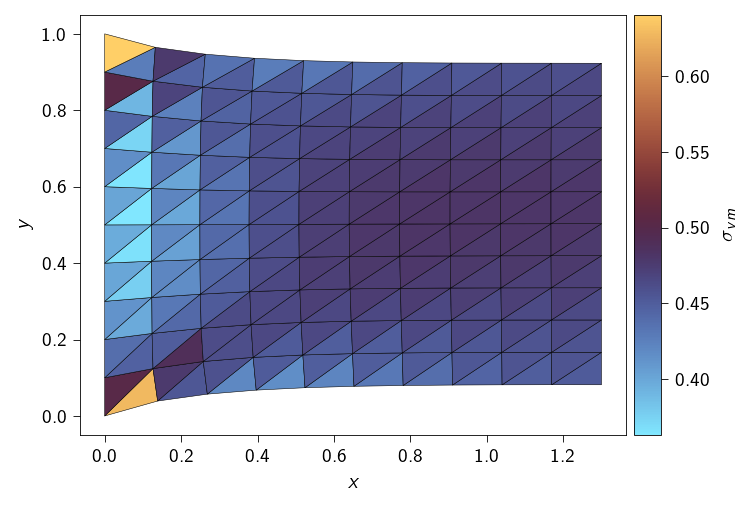

In [35]:
#| code-fold: true
#| fig-align: center

from femsolver.plotting import STYLE_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_displacement_and_stress(u, mesh, stress, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements
    
    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax, label=r"$\sigma_{vm}$")
    plt.show()

# --- Plot the displacement and stress ---
plot_displacement_and_stress(u_solution, mesh, stress_vm.flatten())